# Running all of the Images Through the Model

In [1]:
import os
import cv2
import torch
from torchvision import transforms
from PIL import Image  # Import PIL for image conversion

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/images"
masks_dir = "/Users/maryamrehmatulla/Desktop/masks"  # Assuming masks are in the same directory

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

def preprocess_data(images_dir, masks_dir, transform):
    images = []
    masks = []
    
    # Iterate through images in the directory
    for img_name in os.listdir(images_dir):
        if not img_name.endswith('.png'):  # Ensure only PNG files are processed
            continue
        
        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, img_name)  # Assuming mask names are the same as image names
        
        # Read images and masks
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        
        # Check if images are loaded properly
        if img is None or mask is None:
            continue
        
        # Apply transformations
        img = transform(img)
        mask = transform(mask)
        
        # Append to lists
        images.append(img)
        masks.append(mask)
    
    return images, masks

# Preprocess data
images, masks = preprocess_data(images_dir, masks_dir, transform)

# Convert lists to PyTorch tensors
images_tensor = torch.stack(images)
masks_tensor = torch.stack(masks)

# Print shapes for verification
print(f"Images tensor shape: {images_tensor.shape}")
print(f"Masks tensor shape: {masks_tensor.shape}")


libpng error: Read Error
[ WARN:0@25.325] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3pk7il193907277eut0ch3.png'): can't open/read file: check file path/integrity
[ WARN:0@45.479] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3oto5m0yc80786qsy7y91p.png'): can't open/read file: check file path/integrity
[ WARN:0@79.945] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3oto5m0yce0786fj6ycmv0.png'): can't open/read file: check file path/integrity
[ WARN:0@90.015] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3oto5m0ybh0786y4w83yxp.png'): can't open/read file: check file path/integrity
[ WARN:0@98.033] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3nafw517kz0727kn6krqzc.png'): can't open/read file: check file path/integrity
libpng error: IDAT: CRC error
[ WARN:0@115.605] global loadsave.cpp:24

Images tensor shape: torch.Size([84, 3, 256, 256])
Masks tensor shape: torch.Size([84, 1, 256, 256])


Epoch 0/59
----------
LR 0.0001


/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.685334, dice: 0.990619, loss: 0.837976
val: bce: 0.675111, dice: 0.990094, loss: 0.832603
saving best model
1m 23s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.668666, dice: 0.990571, loss: 0.829618
val: bce: 0.656102, dice: 0.990048, loss: 0.823075
saving best model
1m 25s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.645809, dice: 0.990518, loss: 0.818163
val: bce: 0.625637, dice: 0.989988, loss: 0.807812
saving best model
1m 24s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.607992, dice: 0.990454, loss: 0.799223
val: bce: 0.571054, dice: 0.989917, loss: 0.780485
saving best model
1m 26s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.534483, dice: 0.990395, loss: 0.762439
val: bce: 0.449048, dice: 0.989965, loss: 0.719507
saving best model
1m 26s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.336574, dice: 0.991055, loss: 0.663815
val: bce: 0.092028, dice: 0.995048, loss: 0.543538
saving best model
1m 26s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.103769, dice: 0.9951

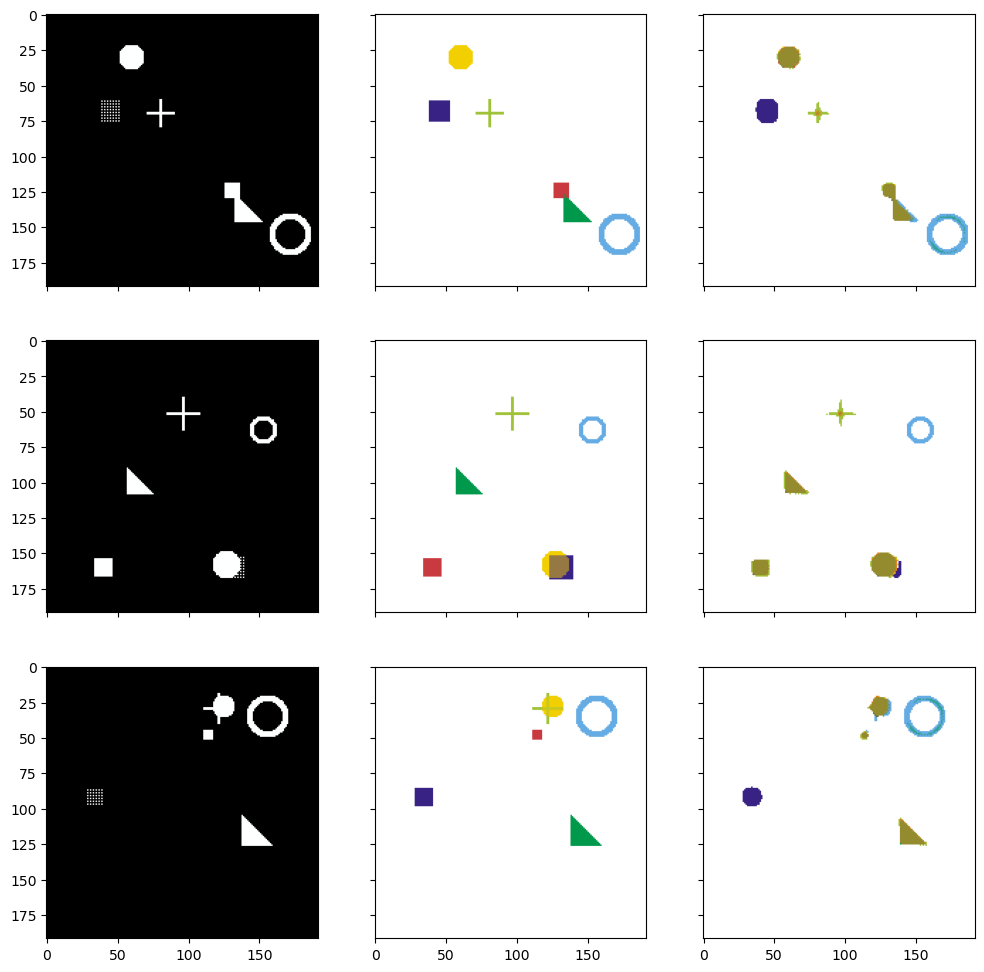

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have images_tensor and masks_tensor from your preprocessing step
dataset = TensorDataset(images_tensor, masks_tensor)
batch_size = 2  # Adjust batch size as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

from Model import UNet  # Import your U-Net model

# Instantiate your U-Net model
model = UNet(n_class=1)  # Adjust n_class according to your task (e.g., number of classes for segmentation)

# Load model weights if needed
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))

model.eval()  # Set model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device

predictions = []

# Iterate through the DataLoader for inference
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        
        # Perform inference
        outputs = model(images)
        
        # Assuming your model outputs logits, you might want to apply a sigmoid activation for probabilities
        # For example:
        # outputs = torch.sigmoid(outputs)
        
        # Append predictions (outputs) to the list
        predictions.append(outputs.cpu().detach())  # Detach and move to CPU if necessary

# Convert predictions list to a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Print or process predictions as needed
print(f"Predictions tensor shape: {predictions_tensor.shape}")



In [7]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score

def calculate_metrics(predictions, targets, threshold=0.5):
    # Apply sigmoid to predictions and threshold to get binary masks
    predictions = torch.sigmoid(predictions)
    binary_predictions = (predictions > threshold).float()
    
    # Ensure targets are binary (0 or 1)
    binary_targets = (targets > threshold).float()
    
    # Flatten the tensors for metric calculation
    pred_flat = binary_predictions.view(-1).cpu().numpy()
    target_flat = binary_targets.view(-1).cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Calculate precision
    precision = precision_score(target_flat, pred_flat)
    
    return accuracy, precision

# Assuming predictions_tensor contains your model's predictions
# and normalized_masks_tensor contains your ground truth masks
accuracies = []
precisions = []

for pred, target in zip(predictions_tensor, normalized_masks_tensor):
    acc, prec = calculate_metrics(pred, target)
    accuracies.append(acc)
    precisions.append(prec)

# Calculate average metrics
average_accuracy = sum(accuracies) / len(accuracies)
average_precision = sum(precisions) / len(precisions)

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")


/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 0.9974
Average Precision: 0.0000


# Splitting Up the Images Between Sets

In [11]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from Model import UNet  # Import your U-Net model
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/images"
masks_dir = "/Users/maryamrehmatulla/Desktop/masks"

# Get all image filenames
all_images = [f for f in os.listdir(images_dir) if f.startswith('image') and f.endswith('.png')]

# Ensure that we have corresponding mask files
all_images = [f for f in all_images if os.path.exists(os.path.join(masks_dir, f.replace('image', 'mask')))]

# Sort the image filenames to ensure consistent ordering
all_images.sort()

# Create a dictionary to map each image filename to its corresponding mask filename
image_to_mask = {}
for img_name in all_images:
    mask_name = img_name.replace('image', 'mask')
    image_to_mask[img_name] = mask_name

# Split data into training, validation, and testing sets (80%, 10%, 10%)
train_images, val_test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Testing images: {len(test_images)}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

def preprocess_data(image_list, images_dir, masks_dir, transform):
    images = []
    masks = []
    
    for img_name in image_list:
        img_path = os.path.join(images_dir, img_name)
        mask_name = image_to_mask[img_name]
        mask_path = os.path.join(masks_dir, mask_name)  # Assuming mask names are the same as image names
        
        try:
            # Read images and masks
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            # Apply transformations
            img = transform(img)
            mask = transform(mask)
            
            # Append to lists
            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")
    
    return torch.stack(images), torch.stack(masks)

# Preprocess data
train_images_tensor, train_masks_tensor = preprocess_data(train_images, images_dir, masks_dir, transform)
val_images_tensor, val_masks_tensor = preprocess_data(val_images, images_dir, masks_dir, transform)
test_images_tensor, test_masks_tensor = preprocess_data(test_images, images_dir, masks_dir, transform)

print(f"Train images tensor shape: {train_images_tensor.shape}")
print(f"Validation images tensor shape: {val_images_tensor.shape}")
print(f"Test images tensor shape: {test_images_tensor.shape}")

# Convert datasets to TensorDataset
train_dataset = TensorDataset(train_images_tensor, train_masks_tensor)
val_dataset = TensorDataset(val_images_tensor, val_masks_tensor)
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)

# Define batch size
batch_size = 2

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate your U-Net model
model = UNet(n_class=1)  # Adjust n_class according to your task (e.g., number of classes for segmentation)

# Load model weights if needed
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))

model.eval()  # Set model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device

# Function to perform inference and calculate metrics
def evaluate_model(loader):
    predictions = []
    targets = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            
            # Perform inference
            outputs = model(images)
            
            # Assuming your model outputs logits, you might want to apply a sigmoid activation for probabilities
            # For example:
            # outputs = torch.sigmoid(outputs)
            
            # Append predictions (outputs) and targets (masks) to the lists
            predictions.append(outputs.cpu())
            targets.append(masks.cpu())  # Move to CPU for compatibility with sklearn metrics
    
    # Concatenate predictions and targets
    predictions_tensor = torch.cat(predictions, dim=0)
    targets_tensor = torch.cat(targets, dim=0)
    
    # Calculate metrics
    accuracy, precision = calculate_metrics(predictions_tensor, targets_tensor)
    
    return accuracy, precision

# Function to calculate metrics
def calculate_metrics(predictions, targets, threshold=0.5):
    # Apply sigmoid to predictions and threshold to get binary masks
    predictions = torch.sigmoid(predictions)
    binary_predictions = (predictions > threshold).float()
    
    # Ensure targets are binary (0 or 1)
    binary_targets = (targets > threshold).float()
    
    # Flatten the tensors for metric calculation
    pred_flat = binary_predictions.view(-1).cpu().numpy()
    target_flat = binary_targets.view(-1).cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Calculate precision
    precision = precision_score(target_flat, pred_flat, zero_division=0)
    
    return accuracy, precision

# Evaluate model on test set
test_accuracy, test_precision = evaluate_model(test_loader)
print(f"Test Set - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}")

# Evaluate model on validation set
val_accuracy, val_precision = evaluate_model(val_loader)
print(f"Validation Set - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}")


Training images: 77
Validation images: 10
Testing images: 10
Error processing file image46.png: broken PNG file (chunk b'\x00\x00\x00\x00')
Error processing file image38.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask38.png'
Error processing file image73.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask73.png'
Error processing file image43.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask43.png'
Error processing file image56.png: image file is truncated
Error processing file image70.png: broken PNG file (chunk b'\x00\x00\x00\x00')
Error processing file image37.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask37.png'
Error processing file image67.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask67.png'
Train images tensor shape: torch.Size([70, 3, 256, 256])
Validation images tensor shape: torch.Size([10, 3, 256, 256])
Test images tensor shape: torch.Size([

Training images: 77
Validation images: 10
Testing images: 10
Error processing file image46.png: broken PNG file (chunk b'\x00\x00\x00\x00')
Error processing file image38.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask38.png'
Error processing file image73.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask73.png'
Error processing file image43.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask43.png'
Error processing file image56.png: image file is truncated
Error processing file image70.png: broken PNG file (chunk b'\x00\x00\x00\x00')
Error processing file image37.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask37.png'
Error processing file image67.png: cannot identify image file '/Users/maryamrehmatulla/Desktop/masks/mask67.png'
Train images tensor shape: torch.Size([70, 3, 256, 256])
Validation images tensor shape: torch.Size([10, 3, 256, 256])
Test images tensor shape: torch.Size([

/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set - Accuracy: 0.4359, Precision: 0.0000, F1-Score: 0.0000, IoU: 0.0000


/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Set - Accuracy: 0.4282, Precision: 0.0000, F1-Score: 0.0000, IoU: 0.0000


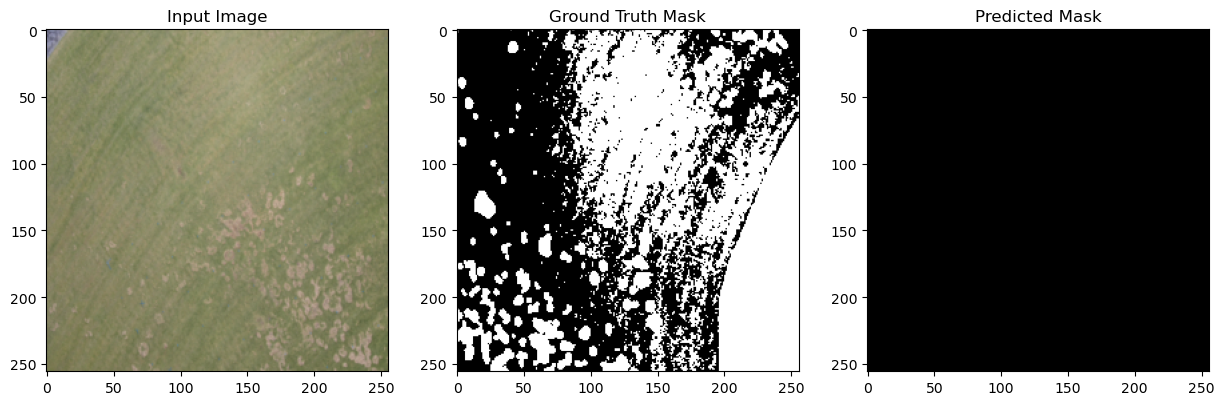

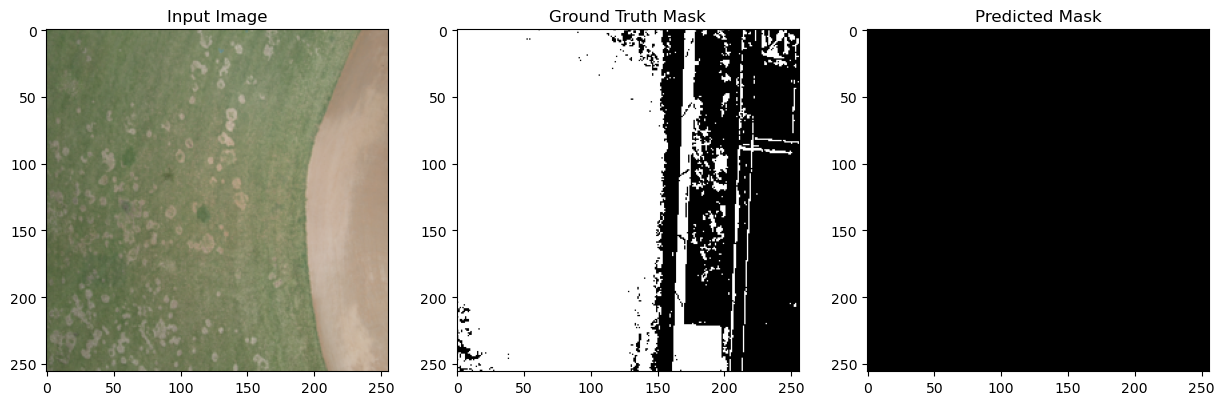

In [23]:
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, jaccard_score
from Model import UNet  # Import your U-Net model
from PIL import Image

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/images"
masks_dir = "/Users/maryamrehmatulla/Desktop/masks"

# Get all image filenames
all_images = [f for f in os.listdir(images_dir) if f.startswith('image') and f.endswith('.png')]

# Ensure that we have corresponding mask files
all_images = [f for f in all_images if os.path.exists(os.path.join(masks_dir, f.replace('image', 'mask')))]

# Sort the image filenames to ensure consistent ordering
all_images.sort()

# Create a dictionary to map each image filename to its corresponding mask filename
image_to_mask = {}
for img_name in all_images:
    mask_name = img_name.replace('image', 'mask')
    image_to_mask[img_name] = mask_name

# Split data into training, validation, and testing sets (80%, 10%, 10%)
train_images, val_test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Testing images: {len(test_images)}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

def preprocess_data(image_list, images_dir, masks_dir, transform):
    images = []
    masks = []
    
    for img_name in image_list:
        img_path = os.path.join(images_dir, img_name)
        mask_name = image_to_mask[img_name]
        mask_path = os.path.join(masks_dir, mask_name)
        
        try:
            # Read images and masks
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            # Apply transformations
            img = transform(img)
            mask = transform(mask)
            
            # Binarize the mask
            mask = (mask > 0.5).float()
            
            # Append to lists
            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")
    
    return torch.stack(images), torch.stack(masks)

# Preprocess data
train_images_tensor, train_masks_tensor = preprocess_data(train_images, images_dir, masks_dir, transform)
val_images_tensor, val_masks_tensor = preprocess_data(val_images, images_dir, masks_dir, transform)
test_images_tensor, test_masks_tensor = preprocess_data(test_images, images_dir, masks_dir, transform)

print(f"Train images tensor shape: {train_images_tensor.shape}")
print(f"Validation images tensor shape: {val_images_tensor.shape}")
print(f"Test images tensor shape: {test_images_tensor.shape}")

# Convert datasets to TensorDataset
train_dataset = TensorDataset(train_images_tensor, train_masks_tensor)
val_dataset = TensorDataset(val_images_tensor, val_masks_tensor)
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)

# Define batch size
batch_size = 2

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate your U-Net model
model = UNet(n_class=1)  # Adjust n_class according to your task (e.g., number of classes for segmentation)

# Load model weights if needed
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))

model.eval()  # Set model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device

# Function to perform inference and calculate metrics
def evaluate_model(loader):
    predictions = []
    targets = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Perform inference
            outputs = model(images)
            
            # Apply sigmoid activation to get probabilities
            outputs = torch.sigmoid(outputs)
            
            # Append predictions (outputs) and targets (masks) to the lists
            predictions.append(outputs.cpu())
            targets.append(masks.cpu())
    
    # Concatenate predictions and targets
    predictions_tensor = torch.cat(predictions, dim=0)
    targets_tensor = torch.cat(targets, dim=0)
    
    # Threshold predictions to get binary masks
    binary_predictions_tensor = (predictions_tensor > 0.5).float()
    
    # Ensure targets are binary
    binary_targets_tensor = (targets_tensor > 0.5).float()
    
    # Calculate metrics
    accuracy, precision, f1, iou = calculate_metrics(binary_predictions_tensor, binary_targets_tensor)
    
    return accuracy, precision, f1, iou

# Function to calculate metrics
def calculate_metrics(predictions, targets):
    # Flatten the tensors for metric calculation
    pred_flat = predictions.view(-1).cpu().numpy()
    target_flat = targets.view(-1).cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Calculate precision
    precision = precision_score(target_flat, pred_flat)
    
    # Calculate F1-score
    f1 = f1_score(target_flat, pred_flat)
    
    # Calculate IoU (Intersection over Union)
    iou = jaccard_score(target_flat, pred_flat)
    
    return accuracy, precision, f1, iou

# Evaluate model on test set
test_accuracy, test_precision, test_f1, test_iou = evaluate_model(test_loader)
print(f"Test Set - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, F1-Score: {test_f1:.4f}, IoU: {test_iou:.4f}")

# Evaluate model on validation set
val_accuracy, val_precision, val_f1, val_iou = evaluate_model(val_loader)
print(f"Validation Set - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, F1-Score: {val_f1:.4f}, IoU: {val_iou:.4f}")

# Function to visualize predictions
def visualize_predictions(images, masks, predictions, num_images=5):
    import matplotlib.pyplot as plt
    
    # Ensure num_images does not exceed available images
    num_images = min(num_images, images.shape[0])
    
    for i in range(num_images):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title('Input Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        
        plt.show()

# Visualize predictions for test set
test_images_subset = test_images_tensor[:2]  # Adjusted to select the first 2 images
test_masks_subset = test_masks_tensor[:2]    # Adjusted to select masks corresponding to the first 2 images
test_images_subset = test_images_subset.to(device)
test_masks_subset = test_masks_subset.to(device)

model.eval()
with torch.no_grad():
    test_predictions_subset = torch.sigmoid(model(test_images_subset))

# Visualize predictions
visualize_predictions(test_images_subset.cpu(), test_masks_subset.cpu(), (test_predictions_subset > 0.5).float().cpu(), num_images=2)


Mask for image62.png not found. Skipping.
Mask for image60.png not found. Skipping.
Mask for image70.png not found. Skipping.
Mask for image72.png not found. Skipping.
Mask for image12.png not found. Skipping.
Mask for image10.png not found. Skipping.
Mask for image20.png not found. Skipping.
Mask for image22.png not found. Skipping.
Mask for image32.png not found. Skipping.
Mask for image30.png not found. Skipping.


libpng error: Read Error


Mask for image42.png not found. Skipping.
Mask for image80.png not found. Skipping.
Mask for image100.png not found. Skipping.
Mask for image102.png not found. Skipping.
Mask for image82.png not found. Skipping.
Mask for image40.png not found. Skipping.
Mask for image50.png not found. Skipping.
Mask for image92.png not found. Skipping.
Mask for image90.png not found. Skipping.
Mask for image52.png not found. Skipping.
Training set: torch.Size([67, 3, 256, 256]), torch.Size([67, 1, 256, 256])
Testing set: torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 256, 256])
Validation set: torch.Size([9, 3, 256, 256]), torch.Size([9, 1, 256, 256])


/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set - Accuracy: 0.3666, Precision: 0.0000


IndexError: index 2 is out of bounds for dimension 0 with size 2

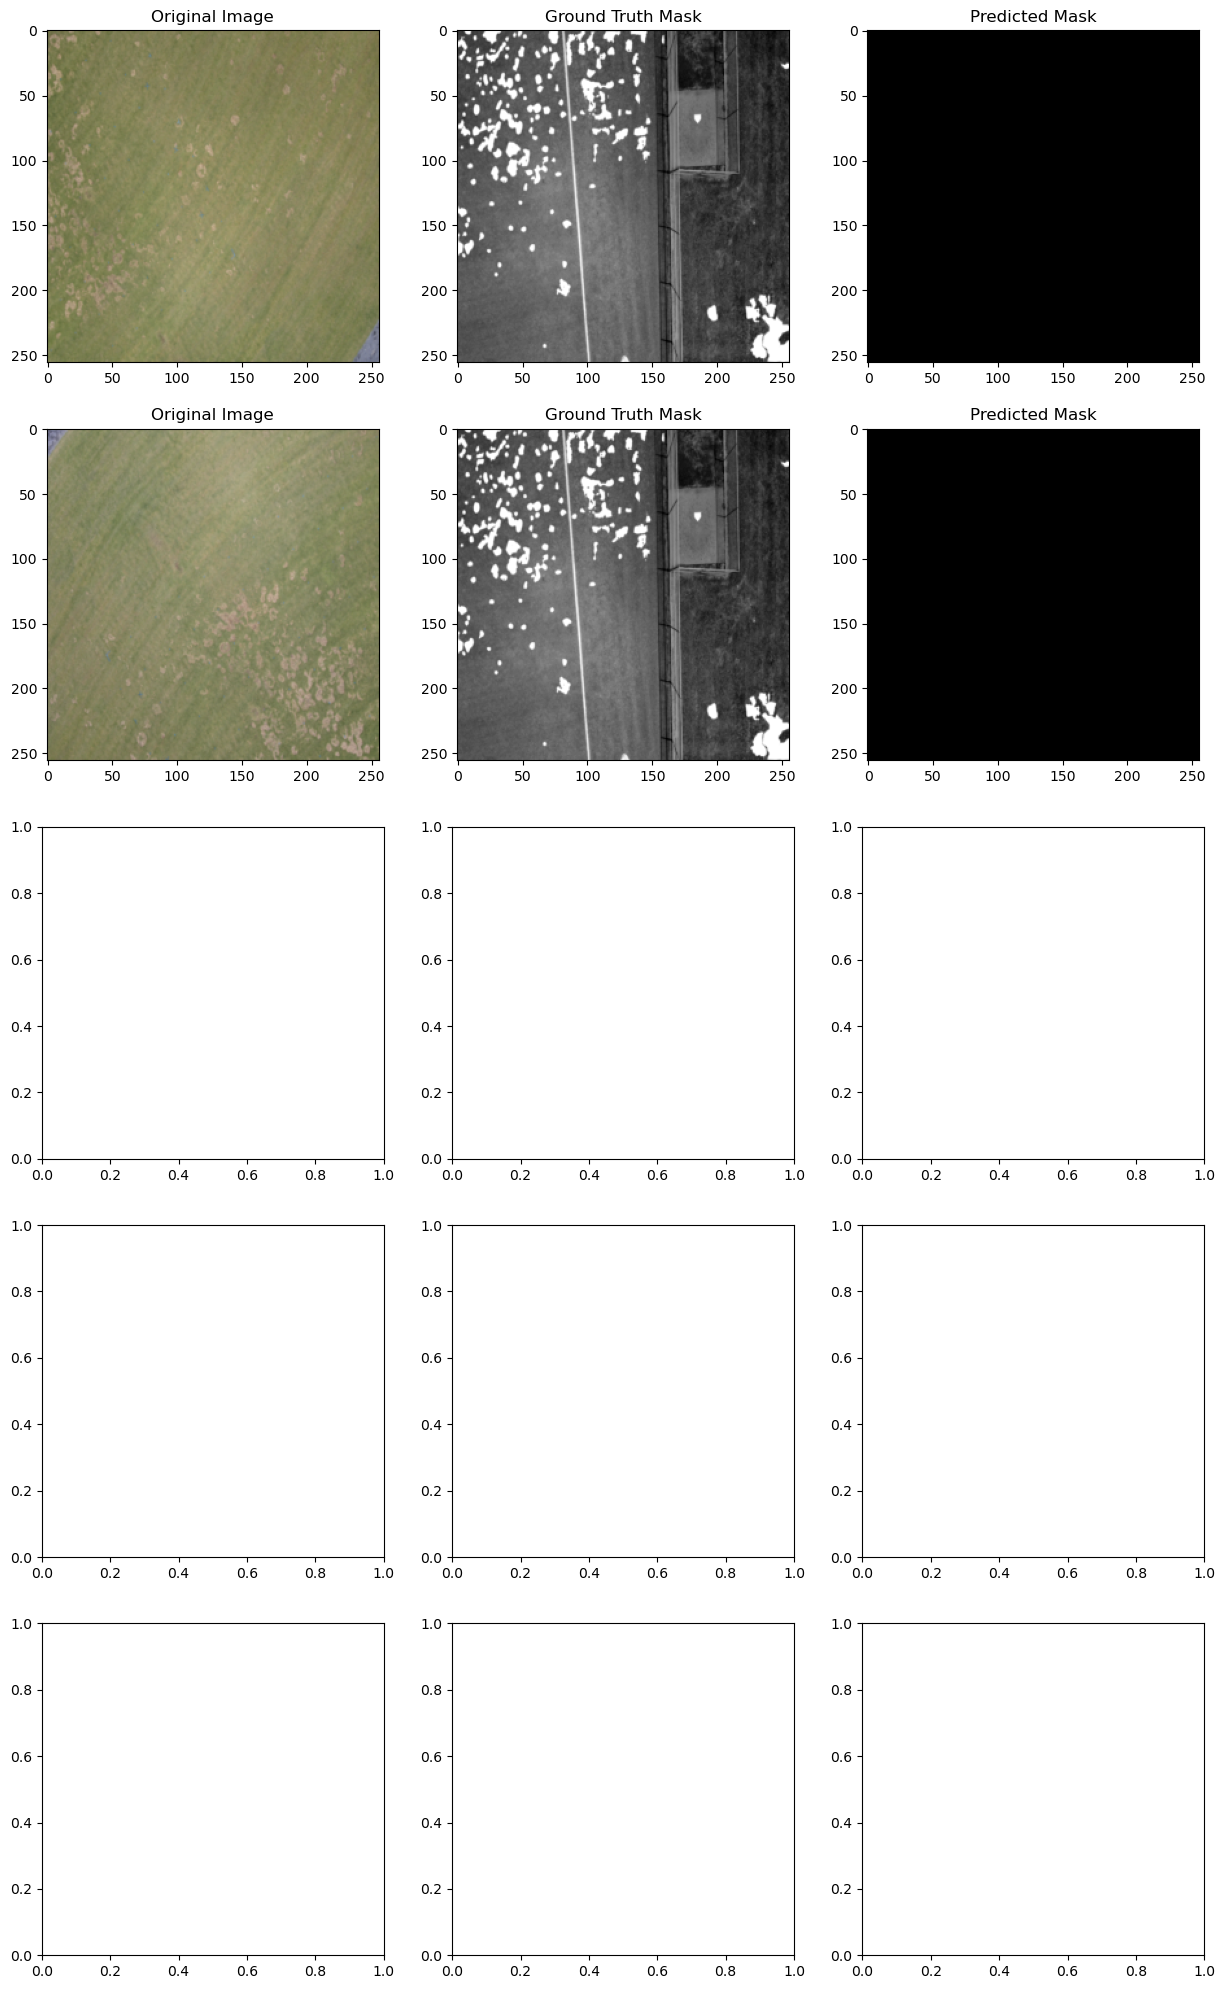

In [22]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from Model import UNet  # Import your U-Net model
from PIL import Image

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/images"
masks_dir = "/Users/maryamrehmatulla/Desktop/masks"  # Assuming masks are in the same directory

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

def preprocess_data(images_dir, masks_dir, transform):
    images = []
    masks = []
    
    # Get list of all image filenames
    image_files = os.listdir(images_dir)
    
    # Iterate through images in the directory
    for img_name in image_files:
        if not img_name.endswith('.png'):  # Ensure only PNG files are processed
            continue
        
        img_path = os.path.join(images_dir, img_name)
        
        # Construct mask filename based on image filename
        mask_name = f"mask{img_name.split('.')[0][-1]}.png"  # Assuming masks are named like 'mask1.png', 'mask2.png', etc.
        mask_path = os.path.join(masks_dir, mask_name)
        
        # Check if mask file exists
        if not os.path.exists(mask_path):
            print(f"Mask for {img_name} not found. Skipping.")
            continue
        
        # Read images and masks
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        
        # Check if images are loaded properly
        if img is None or mask is None:
            continue
        
        # Apply transformations
        img = transform(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))  # Convert BGR to RGB before transforming
        mask = transform(mask)
        
        # Append to lists
        images.append(img)
        masks.append(mask)
    
    return images, masks


# Preprocess data
images, masks = preprocess_data(images_dir, masks_dir, transform)

# Convert lists to PyTorch tensors
images_tensor = torch.stack(images)
masks_tensor = torch.stack(masks)

# Split dataset into training, testing, and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(images_tensor, masks_tensor, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Print shapes for verification
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Convert datasets to TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

# Define batch size
batch_size = 2

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate your U-Net model
model = UNet(n_class=1)  # Adjust n_class according to your task (e.g., number of classes for segmentation)

# Load model weights if needed
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))

model.eval()  # Set model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device

# Function to perform inference and calculate metrics
def evaluate_model(loader):
    predictions = []
    targets = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            
            # Perform inference
            outputs = model(images)
            
            # Assuming your model outputs logits, you might want to apply a sigmoid activation for probabilities
            # For example:
            # outputs = torch.sigmoid(outputs)
            
            # Append predictions (outputs) and targets (masks) to the lists
            predictions.append(outputs.cpu())
            targets.append(masks.cpu())  # Move to CPU for compatibility with sklearn metrics
    
    # Concatenate predictions and targets
    predictions_tensor = torch.cat(predictions, dim=0)
    targets_tensor = torch.cat(targets, dim=0)
    
    # Calculate metrics
    accuracy, precision = calculate_metrics(predictions_tensor, targets_tensor)
    
    return accuracy, precision

# Function to calculate metrics
def calculate_metrics(predictions, targets, threshold=0.5):
    # Apply sigmoid to predictions and threshold to get binary masks
    predictions = torch.sigmoid(predictions)
    binary_predictions = (predictions > threshold).float()
    
    # Ensure targets are binary (0 or 1)
    binary_targets = (targets > threshold).float()
    
    # Flatten the tensors for metric calculation
    pred_flat = binary_predictions.view(-1).cpu().numpy()
    target_flat = binary_targets.view(-1).cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Calculate precision
    precision = precision_score(target_flat, pred_flat)
    
    return accuracy, precision

# Function to visualize predictions
def visualize_predictions(images, masks, predictions, num_images=5):
    images = images[:num_images]
    masks = masks[:num_images]
    predictions = predictions[:num_images]
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title('Original Image')
        
        # Plot ground truth mask
        axes[i, 1].imshow(masks[i][0], cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        
        # Plot predicted mask
        axes[i, 2].imshow(predictions[i][0], cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
    
    plt.tight_layout()
    plt.show()

# Evaluate model on test set
test_accuracy, test_precision = evaluate_model(test_loader)
print(f"Test Set - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}")

# Perform inference on a few test images and visualize
with torch.no_grad():
    test_images, test_masks = next(iter(test_loader))  # Get a batch of test images and masks
    test_images = test_images.to(device)
    test_predictions = torch.sigmoid(model(test_images))
    
visualize_predictions(test_images.cpu(), test_masks.cpu(), (test_predictions > 0.5).float().cpu(), num_images=5)
